In [1]:
#Section 2
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Data loading
excel_filepath = '/Users/kaiwentay/Downloads/FinMath Programme/FIN 36700/Homework 2/proshares_analysis_data.xlsx'

proshares_des = pd.read_excel(excel_filepath, sheet_name = "descriptions", index_col = 0)
proshares_series = pd.read_excel(excel_filepath, sheet_name = "hedge_fund_series", index_col = 0)
proshares_factors = pd.read_excel(excel_filepath, sheet_name = "merrill_factors", index_col = 0)
proshares_other = pd.read_excel(excel_filepath, sheet_name = "other_data", index_col = 0)

In [7]:
#Section 2.1, 2.2
def hedge_fund_stats(data, input_freq, output_freq, excess = None, type = None):
    
    multiplier = 1

    if type == "Business":
        daily = 252
    else:
        daily = 365

    if input_freq == 'Daily':
        multiplier *= daily
    elif input_freq == 'Monthly':
        multiplier *= 12
    elif input_freq == 'Annually':
        multiplier *= 1

    if output_freq == 'Daily':
        multiplier *= 1/daily
    elif output_freq == 'Monthly':
        multiplier *= 1/12
    elif output_freq == 'Annually':
        multiplier *= 1
    
    summary = data.mean().to_frame('Mean').apply(lambda x: x * multiplier)
    summary['Variance'] = data.var().apply(lambda x: x * multiplier)
    summary['Volatility'] = summary['Variance'].apply(lambda x: x ** 0.5)
    summary['Sharpe'] = summary['Mean'] / summary['Volatility']
    summary['Skew'] = data.skew()
    summary['Excess Kurtosis'] = data.kurtosis()
    summary['5% VaR'] = data.quantile(0.05, axis=0)
    summary['5% CVaR'] = data[data <= data.quantile(0.05, axis=0)].mean()

    cum_returns = (1 + data).cumprod()
    peaks = cum_returns.cummax()
    drawdrowns = (cum_returns - peaks) / peaks

    summary['Max Drawdown'] = drawdrowns.min()
    summary['Bottom Date'] = drawdrowns.idxmin()

    peak_dates = []
    for column in peaks.columns:
        curr_peak = peaks[column]
        curr_drawdown = drawdrowns[column]
        min_drawdown = curr_drawdown.idxmin()
        peak_subset = curr_peak[:min_drawdown]
        peak_index = peak_subset.idxmax()
        peak_dates.append(peak_index)
    summary['Peak Date'] = peak_dates

    recovery_date = []
    for column in cum_returns.columns:
        prev_max = peaks[column][:drawdrowns[column].idxmin()].max()
        recovery = pd.DataFrame([cum_returns[column][drawdrowns[column].idxmin():]]).T
        recovery_date.append(recovery[recovery[column] >= prev_max].index.min())
    summary['Recovery'] = recovery_date

    return summary

hedge_fund_stats(proshares_series, input_freq = 'Monthly', output_freq = 'Annually', excess = 3)
#print("""This is probably a question regarding tracking strength of various indices. """)


,Mean,Variance,Volatility,Sharpe,Skew,Excess Kurtosis,5% VaR,5% CVaR,Max Drawdown,Bottom Date,Peak Date,Recovery
HFRIFWI Index,0.043223,0.003627,0.060228,0.717668,-0.983171,5.918307,-0.025130,-0.037478,-0.115473,2020-03-31,2019-12-31,2020-08-31
MLEIFCTR Index,0.031885,0.003245,0.056966,0.559721,-0.255827,1.664342,-0.028656,-0.035857,-0.124302,2022-09-30,2021-06-30,NaT
MLEIFCTX Index,0.030399,0.003227,0.056806,0.535142,-0.241814,1.631565,-0.028927,-0.035816,-0.124388,2022-09-30,2021-06-30,NaT
HDG US Equity,0.020513,0.003524,0.059367,0.345534,-0.243959,1.780069,-0.031158,-0.037576,-0.140721,2022-09-30,2021-06-30,NaT
QAI US Equity,0.019611,0.002506,0.050062,0.391729,-0.458360,1.737586,-0.020086,-0.032696,-0.137716,2022-09-30,2021-06-30,NaT


In [30]:
#section 2.3
import  statsmodels.api as sm

def reg_based_stats(data, benchmark, rf):
    
    betadata = pd.DataFrame(columns = ['Fund', 'Beta'])
    
    for column in data.columns:
        factors = pd.concat([benchmark, rf], axis = 1)
        x = sm.add_constant(factors)
        y = data[column] - rf
        model = sm.OLS(y, x, missing = 'drop').fit()
        beta = model.params['SPY US Equity']

        er = y.mean() * 12
        tr = er / beta
        err = y.std() * (12 ** 0.5)
        ir = er / err
        
        betadata = betadata.append({'Fund': column, 'Beta': beta, 'Treynor Ratio': tr, 'Information Ratio': ir}, ignore_index = True)

    return betadata

reg_based_stats(proshares_series, proshares_factors['SPY US Equity'], proshares_factors['USGG3M Index'])

/var/folders/53/61_6b7sj45b995hfkyjr5lfh0000gn/T/ipykernel_74979/3528649464.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  betadata = betadata.append({'Fund': column, 'Beta': beta, 'Treynor Ratio': tr, 'Information Ratio': ir}, ignore_index = True)
/var/folders/53/61_6b7sj45b995hfkyjr5lfh0000gn/T/ipykernel_74979/3528649464.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  betadata = betadata.append({'Fund': column, 'Beta': beta, 'Treynor Ratio': tr, 'Information Ratio': ir}, ignore_index = True)
/var/folders/53/61_6b7sj45b995hfkyjr5lfh0000gn/T/ipykernel_74979/3528649464.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  betadata = betadata.append({'Fund': column, 'Beta': beta, 'Treynor Ratio': tr, 'Information Ra

,Fund,Beta,Treynor Ratio,Information Ratio
0,HFRIFWI Index,0.348631,0.097065,0.559617
1,MLEIFCTR Index,0.349748,0.064336,0.394743
2,MLEIFCTX Index,0.348445,0.060314,0.369660
3,HDG US Equity,0.359494,0.030960,0.187356
4,QAI US Equity,0.296297,0.034517,0.204722


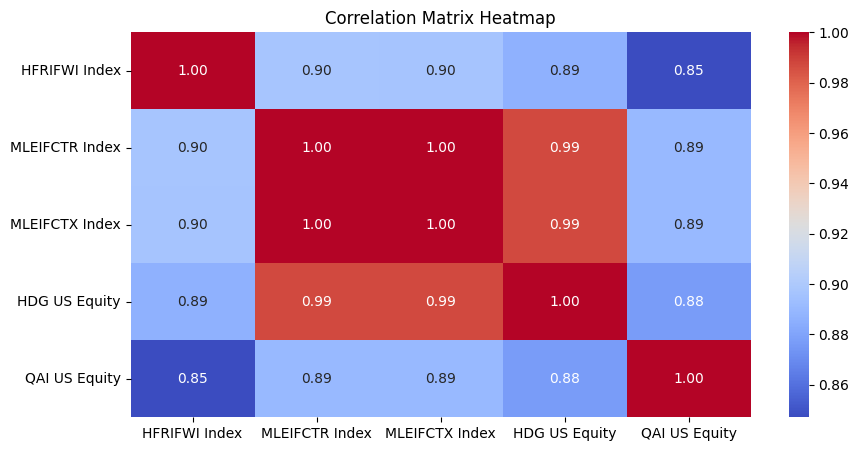

In [18]:
#section 2.5
import seaborn as sns

corr_matrix = proshares_series.corr()
plt.figure(figsize=(10, 5))  # Adjust the figure size as needed
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

In [23]:
#section 2.6
def replicate_regression(factors, fund):
    x = sm.add_constant(factors)
    m = sm.OLS(fund, x, missing = 'drop').fit()
    coeff = m.params
    replication = m.predict(x)
    R_2 = m.rsquared
    residual = fund - replication
    error = np.std(residual)

    results_df = pd.DataFrame({
        'Factor': x.columns,
        'Coefficient': coeff
    })
    results_df = results_df.append({'Factor': 'Intercept', 'Coefficient': coeff['const']}, ignore_index=True)
    results_df = results_df.append({'Factor': 'R-squared', 'Coefficient': R_2}, ignore_index=True)
    results_df = results_df.append({'Factor': 'Error Volatility', 'Coefficient': error}, ignore_index=True)

    return results_df, replication

replicate_regression(proshares_factors, proshares_series['HFRIFWI Index'])

/var/folders/53/61_6b7sj45b995hfkyjr5lfh0000gn/T/ipykernel_74979/1083909786.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Factor': 'Intercept', 'Coefficient': coeff['const']}, ignore_index=True)
/var/folders/53/61_6b7sj45b995hfkyjr5lfh0000gn/T/ipykernel_74979/1083909786.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Factor': 'R-squared', 'Coefficient': R_2}, ignore_index=True)
/var/folders/53/61_6b7sj45b995hfkyjr5lfh0000gn/T/ipykernel_74979/1083909786.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Factor': 'Error Volatility', 'Coefficient': error}, ignore_index=True)


(             Factor  Coefficient
 0             const     0.001383
 1     SPY US Equity     0.033308
 2      USGG3M Index    -0.165908
 3     EEM US Equity     0.077857
 4     EFA US Equity     0.082410
 5     EUO US Equity     0.022649
 6     IWM US Equity     0.152074
 7         Intercept     0.001383
 8         R-squared     0.836901
 9  Error Volatility     0.006997,
 2011-08-31   -0.028525
 2011-09-30   -0.037517
 2011-10-31    0.047034
 2011-11-30   -0.001420
 2011-12-31   -0.000889
                 ...   
 2023-04-30   -0.000365
 2023-05-31   -0.004049
 2023-06-30    0.021371
 2023-07-31    0.017698
 2023-08-31   -0.015353
 Length: 145, dtype: float64)

In [32]:
#section 2.7
from statsmodels.regression.rolling import RollingOLS

new_data = []
for fund in proshares_series.columns:
    fund_ret = pd.DataFrame(proshares_series[fund].copy())
    rolling_reg = rolling_regression_param(merrill,fund_ret)
    factor_ret = merrill.iloc[rolling_reg.dropna().index.min():]
    one_df = pd.DataFrame(np.ones(factor_ret.shape[0])).T
    one_df.columns = factor_ret.index
    factor_ret = pd.concat([one_df,pd.DataFrame(factor_ret).T])
    df2_lst.append(pd.DataFrame(np.diag(pd.DataFrame(np.array(rolling_reg[59:]) @ np.array(factor_ret))), index = factor_ret.columns, columns = [fund]).T)

rolling_reg_replication = pd.concat(new_data)
rolling_reg_replication.T

rolling_reg_performance = performance_summary(rolling_reg_replication.T)
rolling_reg_performance.loc[['HFRIFWI Index']]

NameError: name 'rolling_regression_param' is not defined